# Amazon Sentiment Analysis with NLP

Kozmos, which produces home textiles and daily wear and sells through Amazon,
It increases its sales by analyzing the comments on its products and improving its features according to the complaints it receives.
aims to increase. In line with this goal, comments will be tagged by sentiment analysis and
A classification model will be created with labeled data.

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from textblob import Word, TextBlob
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from nltk.sentiment import SentimentIntensityAnalyzer
from warnings import filterwarnings

filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.width', 200)


Reading data

In [15]:
df = pd.read_excel("amazon.xlsx")
df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5611 entries, 0 to 5610
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Star     5611 non-null   int64 
 1   HelpFul  5611 non-null   int64 
 2   Title    5559 non-null   object
 3   Review   5593 non-null   object
dtypes: int64(2), object(2)
memory usage: 175.5+ KB


 TEXT PREPROCESSING

a) make all letters lowercase

In [16]:
df['Review']

0                                           Happy with it
1       Good quality material however the panels are m...
2       Product was fun for bedroom windows.<br />Imag...
3        Lo unico que me gustaria es que sean un poco ...
4       Great bang for the buck I can't believe the qu...
                              ...                        
5606    Great product for reasonable money.  Delivered...
5607             Color is way off and panels do not match
5608    These are great for my studio as they compleme...
5609    Brought out the beauty in kids room. They love...
5610    Very cute curtains in my sons room! Thick enou...
Name: Review, Length: 5611, dtype: object

In [17]:
df['Review'] = df['Review'].str.lower()

In [18]:
df['Review']

0                                           happy with it
1       good quality material however the panels are m...
2       product was fun for bedroom windows.<br />imag...
3        lo unico que me gustaria es que sean un poco ...
4       great bang for the buck i can't believe the qu...
                              ...                        
5606    great product for reasonable money.  delivered...
5607             color is way off and panels do not match
5608    these are great for my studio as they compleme...
5609    brought out the beauty in kids room. they love...
5610    very cute curtains in my sons room! thick enou...
Name: Review, Length: 5611, dtype: object

b) remove punctuation

In [19]:
df['Review'] = df['Review'].str.replace('[^\w\s]', '', regex=True)

In [20]:
df['Review']

0                                           happy with it
1       good quality material however the panels are m...
2       product was fun for bedroom windowsbr imagery ...
3        lo unico que me gustaria es que sean un poco ...
4       great bang for the buck i cant believe the qua...
                              ...                        
5606    great product for reasonable money  delivered ...
5607             color is way off and panels do not match
5608    these are great for my studio as they compleme...
5609     brought out the beauty in kids room they love it
5610    very cute curtains in my sons room thick enoug...
Name: Review, Length: 5611, dtype: object

c) extract numeric expressions

In [21]:
df['Review'] = df['Review'].str.replace('\d', '', regex= True)

In [22]:
df['Review']

0                                           happy with it
1       good quality material however the panels are m...
2       product was fun for bedroom windowsbr imagery ...
3        lo unico que me gustaria es que sean un poco ...
4       great bang for the buck i cant believe the qua...
                              ...                        
5606    great product for reasonable money  delivered ...
5607             color is way off and panels do not match
5608    these are great for my studio as they compleme...
5609     brought out the beauty in kids room they love it
5610    very cute curtains in my sons room thick enoug...
Name: Review, Length: 5611, dtype: object

d) stopwords

In [23]:
import nltk

nltk.download('stopwords')
sw = stopwords.words('english')
df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
df['Review']

0                                                   happy
1         good quality material however panels mismatched
2       product fun bedroom windowsbr imagery bit stre...
3       lo unico que gustaria es que sean un poco mas ...
4       great bang buck cant believe quality material ...
                              ...                        
5606    great product reasonable money delivered quick...
5607                               color way panels match
5608    great studio complement entire theme studioliv...
5609                        brought beauty kids room love
5610      cute curtains sons room thick enough keep light
Name: Review, Length: 5611, dtype: object

e) Remove words with fewer than 1000 occurrences from the data.

In [25]:
delete = pd.Series(' '.join(df['Review']).split()).value_counts()[-1000:]
df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in x.split() if x not in delete))

In [26]:
df['Review']

0                                                   happy
1         good quality material however panels mismatched
2       product fun bedroom windowsbr imagery bit stre...
3       lo unico que gustaria es que sean un poco mas ...
4       great bang buck cant believe quality material ...
                              ...                        
5606    great product reasonable money delivered quick...
5607                               color way panels match
5608    great studio complement entire theme area phot...
5609                        brought beauty kids room love
5610      cute curtains sons room thick enough keep light
Name: Review, Length: 5611, dtype: object

f) lemmatization

In [27]:
nltk.download('wordnet')
df['Review'] = df['Review'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [28]:
df['Review']

0                                                   happy
1          good quality material however panel mismatched
2       product fun bedroom windowsbr imagery bit stre...
3       lo unico que gustaria e que sean un poco ma la...
4       great bang buck cant believe quality material ...
                              ...                        
5606    great product reasonable money delivered quick...
5607                                color way panel match
5608    great studio complement entire theme area phot...
5609                         brought beauty kid room love
5610        cute curtain son room thick enough keep light
Name: Review, Length: 5611, dtype: object

TEXT VISUALIZATION

a)Calculate the frequencies of the words contained in the "Review" variable, save it as tf, visualize it with barplot

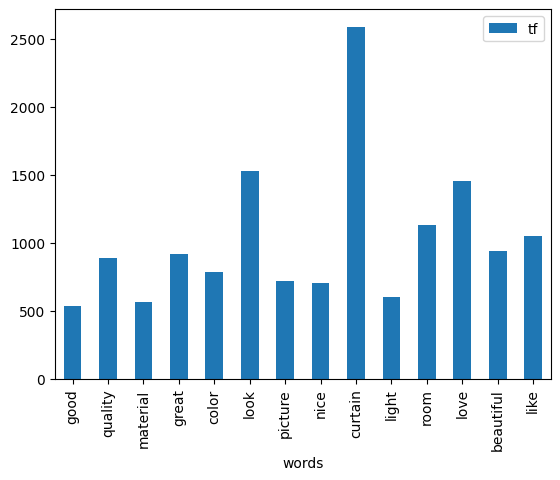

In [29]:
tf = df['Review'].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
tf.columns = ["words", "tf"]
tf.sort_values("tf", ascending=False)
tf[tf["tf"] > 500].plot.bar(x="words", y="tf")
plt.show()

For WordCloud visualization process:<br>
  b)Save all the words contained in the "Review" variable as a string named "text"

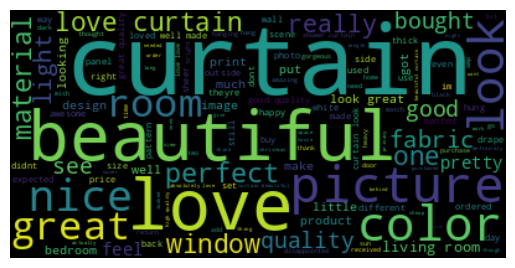

In [30]:
text = " ".join(i for i in df.Review)
#standart versiyon da arka siyah
wordcloud = WordCloud().generate(text) #text formatına getirdiğimiz datamızın içerisindeki freakansı yüksek kelimeleri tespit eder ve görselleştirmemize yardımcı olur.
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

customized version

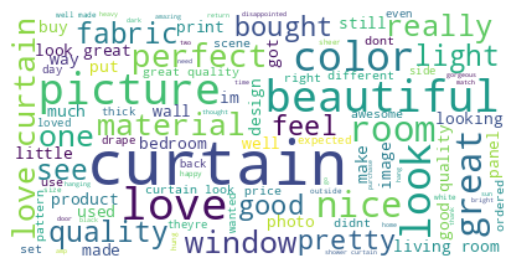

In [31]:
wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Sentiment Analysis

In [33]:
import nltk
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

df['Review'][0:10].apply(lambda x: sia.polarity_scores(x))
df['Review'][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])
df['Review'][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

df['Sentiment_Label'] = df['Review'].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

df.groupby('Sentiment_Label')['Star'].mean()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Sentiment_Label
neg   3.39
pos   4.59
Name: Star, dtype: float64

Preparation for machine learning!<br>
Separate the data as train test by determining our dependent and independent variables.

  ## Test-Train

In [34]:
train_x, test_x, train_y, test_y = train_test_split(df['Review'],
                                                    df['Sentiment_Label'],
                                                    random_state=42)

In order to give data to the machine learning model, we need to convert the representation forms into numerical ones.

In [36]:
tf_idf_word_vectorizer = TfidfVectorizer().fit(train_x)
x_train_tf_idf_word = tf_idf_word_vectorizer.transform(train_x)
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(test_x)

Modeling (Logistic Regression)<br>
Build the logistic regression model and fit it with the train data.


In [37]:
log_model = LogisticRegression().fit(x_train_tf_idf_word, train_y)

y_pred = log_model.predict(x_test_tf_idf_word)

print(classification_report(y_pred, test_y))

cross_val_score(log_model, x_test_tf_idf_word, test_y, cv=5).mean()

              precision    recall  f1-score   support

         neg       0.33      0.90      0.49        82
         pos       0.99      0.89      0.94      1321

    accuracy                           0.89      1403
   macro avg       0.66      0.89      0.71      1403
weighted avg       0.95      0.89      0.91      1403



0.8546034570411795

Let's see how it reacts to a random comment.

In [38]:
random_review = pd.Series(df['Review'].sample(1).values)
new_review = CountVectorizer().fit(train_x).transform(random_review)
pred = log_model.predict(new_review)
print(f'Review:  {random_review[0]} \n Prediction: {pred}')

Review:  love drape good quality great design warms room getting started decorating new place couldnt happier choice drape one bedroom look great antique high ceiling 
 Prediction: ['pos']


Let's see what you will do in the face of bad comments.

In [39]:
bad_review = pd.Series("look at that shit very bad")
bad_review = CountVectorizer().fit(train_x).transform(bad_review)
badprad = log_model.predict(bad_review)
print(f'Review:  {bad_review[0]} \n Prediction: {badprad}')

Review:    (0, 267)	1
  (0, 2256)	1 
 Prediction: ['neg']


Modeling (Random Forest)

In [40]:
rf_model = RandomForestClassifier().fit(x_train_tf_idf_word, train_y)
cross_val_score(rf_model, x_train_tf_idf_word, train_y, cv=5, n_jobs=-1).mean()

0.9134942848831133

In [41]:
#Logistic Regression : 0.8546034570411795
# Random Forest : 0.9153956521616331